# Computer Vision - Fast Nearest Neighbors Algorithms

Author: `Vladislav Belov`

Date: `2020-03`
___

## Preparation of the Environment and Testing of PyFLANN

This section is dedicated to basic needs for reproducibility of results. Here we set up the Anaconda environment (note that the following code is functional also for standard Python installations; however, usage of virtual environments is recommended). We also test the functionality of PyFLANN by construction of a k-NN graph for synthetic data.

In [ ]:
# Installations (assuming that the notebook has been started under a fresh Anaconda virtual environment)
!conda install pip
!pip install 2to3 numpy pyflann scipy matplotlib networkx scikit-learn seaborn pandas tqdm

In [ ]:
# PyFLANN is a Python 2 package. We use Python 3.8.2; therefore, the package needs to be translated into Python 3.
# Following lines of code provide one with the path to Python packages folder.
# Use your path to PyFLANN library to translate it into Python 3.

# from distutils.sysconfig import get_python_lib
# print(get_python_lib())

!2to3 -w /Users/salisare-sama/opt/anaconda3/envs/computer-vision/lib/python3.8/site-packages/pyflann

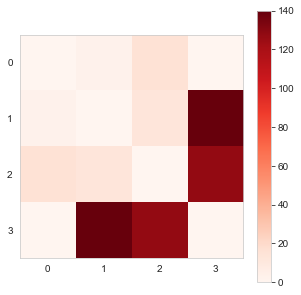

In [14]:
# Test PyFLANN by construction of a simple k-NN graph on synthetic data
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import csr_matrix
from pyflann import *


params = {
    'kdtree': {
        'algorithm': 'kdtree',
        'target_precision': .95,
        'trees': 32
    },
    'kmeans': {
        'algorithm': 'kmeans',
        'branching': 32,
        'iterations': 10,
        'target_precision': .95
    }
}
data = np.array([
    [-1., -1.],
    [1., 1.], 
    [10., 10.], 
    [100., 100.]
])

flann = FLANN()
neighbors, distances = flann.nn(
    data, data, num_neighbors=3, **params['kmeans'])

knn_graph = csr_matrix((np.sqrt(distances.ravel()), 
                        (
                            np.repeat(np.arange(neighbors.shape[0]), 
                                      repeats=neighbors.shape[1]).astype(np.int), 
                            neighbors.ravel().astype(np.int)
                        )
                       ))

# Plot the adjacency matrix
G = nx.from_numpy_array(knn_graph.toarray())
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
pos = ax.imshow(nx.adjacency_matrix(G).toarray(), cmap='Reds', interpolation='none')
fig.colorbar(pos, ax=ax)
ax.set_xticks(np.arange(knn_graph.shape[1], dtype=np.int))
ax.set_yticks(np.arange(knn_graph.shape[0], dtype=np.int))
ax.grid(which='major')
plt.show()

## Data Download

In [ ]:
# Create directories to store data
from pathlib import Path

path = Path('./data/Oxford5K/').resolve()
path.mkdir(parents=True, exist_ok=True)
path = Path('./data/SIFT/').resolve()
path.mkdir(parents=True, exist_ok=True)

# Download raw data
!curl http://cmp.felk.cvut.cz/\~chum/XEP33SAM/imagenames.txt --output data/Oxford5K/imagenames.txt
!curl http://cmp.felk.cvut.cz/\~chum/XEP33SAM/imagedesc.dat --output data/Oxford5K/imagedesc.dat
!curl http://cmp.felk.cvut.cz/\~chum/XEP33SAM/images.zip --output data/Oxford5K/images.zip
!curl http://cmp.felk.cvut.cz/\~chum/XEP33SAM/sift.zip --output data/SIFT/sift.zip
!tar -xf data/Oxford5K/images.zip -C data/Oxford5K/
!tar -xf data/SIFT/sift.zip -C data/SIFT/

## Custom $k$-means Implementation

#### The Implementation

In the comments below, we also explain the meaning of pre-set PyFLANN parameters.

Vectors representing initial cluster centers are hard-coded using sampling from the uniform distribution $U(\alpha, \beta)$ where $\alpha$ and $\beta$ are given by values in the data set (minimum and maximum, respectively). This is only one of many solutions - more optimal ones are available, e.g. $k$-means++.


In [3]:
from typing import Optional
from scipy.spatial.distance import cdist
from time import time
from pyflann import FLANN


class CustomKMeans(object):
    
    # PyFLANN instance
    flann = FLANN()
    
    # FLANN hyperparameters
    # The whole list of FLANN parameters is available here:
    # https://github.com/mariusmuja/flann/blob/master/src/cpp/flann/flann.h
    __N_NEIGHBORS = 1  # number of nearest neighbors to search for
    __N_CHECKS = 75  # number of leaves to check in the search
    params = {
        'kdtree': {
            'algorithm': 'kdtree',
            'num_neighbors': __N_NEIGHBORS,
            'trees': 32,  # number of randomized trees to use
            'checks': __N_CHECKS
        },
        'kmeans': {
            'algorithm': 'kmeans',
            'num_neighbors': __N_NEIGHBORS,
            'branching': 32,  # branching for k-means tree
            'iterations': 20,  # number of iterations per k-means step
            'checks': __N_CHECKS
        }
    }
    
    def __init__(self, 
                 n_centers: int = 2,
                 method: str = 'kmeans',
                 max_iter: int = 30,
                 max_iter_no_progress: int = 10, 
                 tol_progress: np.float = 1e-3, 
                 autotune: np.float = .95,
                 random_state: Optional[int] = 17, 
                 verbose: bool = False):
        
        assert method in {'kmeans', 'kdtree', 'exact'}
        
        # Set target precision in case of autotuning
        if method in {'kmeans', 'kdtree'}:
            self.params[method]['target_precision'] = autotune
        
        self.n_centers = n_centers
        self.method = method
        self.max_iter = max_iter
        self.max_iter_no_progress = max_iter_no_progress
        self.tol_progress = tol_progress
        self.random_state = random_state
        self.verbose = verbose
        
        self._dim = None
        self._n_samples = None
        self.centers_ = None
        self.labels_ = None
        self.stats_ = None
        
    def __reset_stats(self):
        self.stats_ = {
            'measure': [],  # the cost function
            'evaluation': [],  # time to evaluate labels
            'assignment': [],  # time to re-assign labels
            'method': None  # method used to evaluate labels
        }
    
    def __update_stats(self, 
                       measure: np.float, 
                       time_eval: np.float, 
                       time_assign: np.float):
        self.stats_['measure'].append(measure)
        self.stats_['evaluation'].append(time_eval)
        self.stats_['assignment'].append(time_assign)
        
    def fit(self, data: np.ndarray) -> None:
        self._n_samples, self._dim = data.shape
        
        np.random.seed(self.random_state)
        
        # Initialize centers (we use uniform random initialization)
        self.centers_ = np.random.uniform(
            np.min(data), np.max(data), 
            size=self.n_centers * self._dim
        ).reshape(self.n_centers, self._dim).astype(data.dtype)
        
        # Start fitting
        self.__reset_stats()
        self.stats_['method'] = self.method
        progress = self.max_iter_no_progress
        for it in range(self.max_iter):
            
            tic_it = time()

            # Evaluate labels and squared distances
            if self.method in {'kmeans', 'kdtree'}:
                self.labels_, sqdist = self.flann.nn(
                    self.centers_, data, **self.params[self.method])
            else:
                sqpdist = cdist(data, self.centers_, metric='sqeuclidean')
                self.labels_ = sqpdist.argmin(axis=1)
                sqdist = sqpdist[np.arange(self._n_samples), self.labels_]
            toc = time()
            t1 = toc - tic_it
            
            # Update centers
            tic = time()
            for label in range(self.n_centers):
                idx = np.where(self.labels_ == label)[0]
                if len(idx):
                    self.centers_[label] = data[idx].mean(axis=0)
                else:
                    # If the cluster is empty, move its center anyway
                    self.centers_[label] = self.centers_.mean(axis=0)
            toc_it = time()
            t2 = toc_it - tic
            
            # Print progress
            if self.verbose:
                print(f'\t--> iteration {it} '
                      f'has been finished -- {toc_it - tic_it:.3e}s')
                    
            # Check convergence
            p = np.bincount(self.labels_, weights=sqdist).sum() / data.shape[0]
            if it > 1 and self.stats_['measure'][-2] - \
                    self.stats_['measure'][-1] < self.tol_progress:
                progress -= 1
                if not progress:
                    self.__update_stats(p, t1, t2)
                    print(f'\nIteration {it}: '
                          f'no progress during '
                          f'last {self.max_iter_no_progress} iterations')
                    break
            else:
                self.__update_stats(p, t1, t2)
                progress = self.max_iter_no_progress
        
    def fit_predict(self, data: np.ndarray) -> np.ndarray:
        
        self.fit(data)
        
        return self.labels_
    
    def time_report(self):
        if self.stats_ is None:
            print('No statistics are available.')
        else:
            t_eval = np.asarray(self.stats_['evaluation'])
            t_assign = np.asarray(self.stats_['assignment'])
            print(
                f'\nEvaluation time per iteration:\n'
                f'\tAVG. = {t_eval.mean()}s\n'
                f'\tSTD. = {t_eval.std()}s'
            )
            print(
                f'Assignment time per iteration:\n'
                f'\tAVG. = {t_assign.mean()}s\n'
                f'\tSTD. = {t_assign.std()}s'
            )


#### Test of the Implementation

To test the implementation, we apply `CustomKMeans` on randomly generated blobs and plot results.


Iteration 20: no progress during last 10 iterations

Evaluation time per iteration:
	AVG. = 0.00042128562927246094s
	STD. = 7.60618793142486e-05s
Assignment time per iteration:
	AVG. = 0.00023049116134643555s
	STD. = 5.0759937476824854e-05s


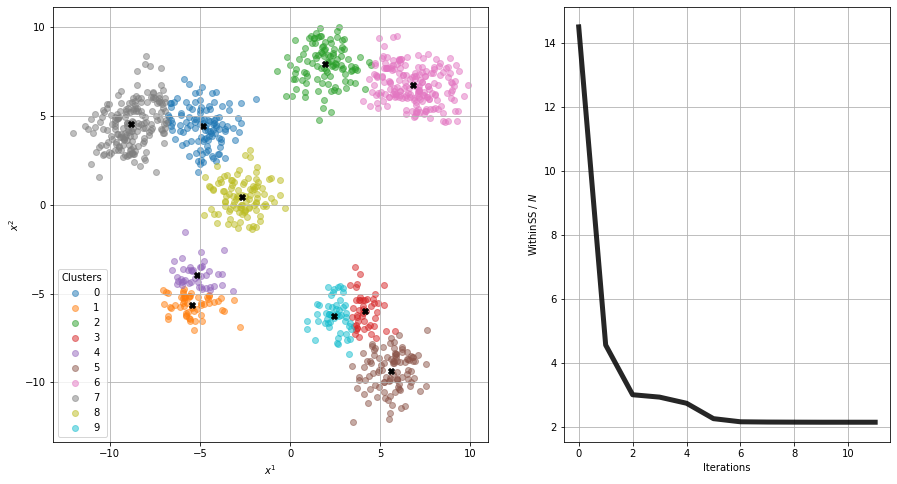

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs


# Generate random data
np.random.seed(17)
N_CENTERS = 10
N_SAMPLES = 1000
DIM = 2
data, _ = make_blobs(
    n_samples=N_SAMPLES, 
    centers=N_CENTERS, 
    n_features=DIM,
    random_state=20
)
# data = np.random.random((N_SAMPLES, DIM)).astype(np.float32)

# Fit using CustomKMeans
km = CustomKMeans(
    n_centers=N_CENTERS, 
    method='kmeans',
    autotune=.95,
    verbose=False
)
km.fit(data)
km.time_report()
centers = km.centers_
labels = km.labels_
measure = km.stats_['measure']

# Plot results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8),
                              gridspec_kw={'width_ratios': (2, 1.5)})
for label in range(N_CENTERS):
    idx = np.where(labels == label)[0]
    ax1.scatter(data[idx, 0], data[idx, 1], label=label, alpha=.5)
    ax1.scatter(centers[label, 0], centers[label, 1], marker='X', s=35, color='k')
ax1.set_xlabel(r'$x^{1}$')
ax1.set_ylabel(r'$x^{2}$')
ax1.legend(loc='best', title='Clusters')
ax2.plot(np.arange(len(measure)), measure, color='k', linewidth=5., alpha=.85)
ax2.set_xlabel('Iterations')
ax2.set_ylabel(r'WithinSS / $N$')
ax1.grid(True)
ax2.grid(True)
plt.show()

## Comparison of NN Approaches in the Approximate $k$-means Framework

In following sections we apply `CustomKMeans` on the SIFT 2M data set using three different methods to assign points to respective cluster centers:

  * k-d tree forest;
  * priority search $k$-means tree;
  * exact assignment.

For each method, we calculate time spent on calculation per iteration and print it. Visual comparison of impact of observed approaches on cost function $\Phi(X) = \frac{1}{N}\sum_{i = 1}^{N} \lVert X_{i} - f(X_{i})\rVert_{2}^{2}$ follows in the next section (we also use "WithinSS / $N$" to denote $\Phi(X)$ on figures).

*Notation*:
  * $X \in \mathbb{R}^{N \times d}$ where $N$ is the number of samples and $d$ is the dimension;
  * $X_{i}$, $i \in \{1, 2, \dots, N\}$, is the $i$-th row of matrix $X$;
  * $\lVert \cdot \rVert_{2}$ is the Euclidean norm $\left( \lVert \cdot \rVert_{2} = \sqrt{\left< \cdot, \cdot \right>} \right)$.

#### Evaluation

Due to extensive computational demands ($N \approx 2$M, $d = 128$), we only fit $150$ cluster centers.

In [5]:
# Load data
import numpy as np
import re


# Oxford5K data
if 0:
    # Process image names
    img_names = []
    with open('./data/Oxford5K/imagenames.txt', mode='r', encoding='utf-8') as file:
        for line in file.readlines():
            img_names.append(re.sub(r'\n', '', line))
    print(f'Found {len(img_names)} image names: {img_names[:3]}')

    # Process descriptors
    X = np.fromfile('./data/Oxford5K/imagedesc.dat', dtype=np.float32)
    X = X.reshape((len(img_names), -1))
    print(f'Descriptors format: {X.shape}')
    
# SIFT data
else:
    # Reading the SIFT data set
    X = np.fromfile('./data/SIFT/SIFT.dat', dtype=np.uint8).astype(np.float32)
    X = X.reshape((-1, 128))
    print(f'Descriptors format: {X.shape}')

Descriptors format: (2097152, 128)


In [6]:
# Evaluate
import pandas as pd


N_CENTERS = 150
AUTO = -1
methods = ['kdtree', 'kmeans', 'exact']
df = pd.DataFrame()
for method in methods:
    print(f'Method: {method}')
    km = CustomKMeans(
        n_centers=N_CENTERS, 
        method=method,
        autotune=AUTO,
        verbose=True
    )
    km.fit(X)
    km.time_report()
    df = pd.concat((df, pd.DataFrame(km.stats_)), axis=0)
    print('=' * 100)
df = df.reset_index(drop=False)
df.to_csv(f'./data/sift_comparison_{N_CENTERS}_auto{AUTO}.csv', index=False)

Method: kdtree
	--> iteration 0 has been finished -- 4.086e+01s
	--> iteration 1 has been finished -- 1.278e+02s
	--> iteration 2 has been finished -- 1.029e+02s
	--> iteration 3 has been finished -- 8.334e+01s
	--> iteration 4 has been finished -- 7.833e+01s
	--> iteration 5 has been finished -- 7.116e+01s
	--> iteration 6 has been finished -- 6.735e+01s
	--> iteration 7 has been finished -- 6.011e+01s
	--> iteration 8 has been finished -- 6.511e+01s
	--> iteration 9 has been finished -- 6.612e+01s
	--> iteration 10 has been finished -- 6.428e+01s
	--> iteration 11 has been finished -- 6.494e+01s
	--> iteration 12 has been finished -- 6.655e+01s
	--> iteration 13 has been finished -- 6.881e+01s
	--> iteration 14 has been finished -- 6.516e+01s
	--> iteration 15 has been finished -- 6.782e+01s
	--> iteration 16 has been finished -- 6.771e+01s
	--> iteration 17 has been finished -- 6.866e+01s
	--> iteration 18 has been finished -- 6.778e+01s
	--> iteration 19 has been finished -- 6.879e

For the current number of centers, the exact approach is still faster that the kd-tree-based one. Nonetheless, during our expirements, we have confirmed that the latter technique outperforms exact assignment in speed.

We also wish to point out that the current implementation of the exact approach performs vector operations and works with large matrices. This method is fast and efficient for smaller data sets; however, for $N \approx 2$M, each iteration demanded a lot of memory:
![alt text](images/flann/poor_ram.png "RAM usage during the exact evaluation")

#### Comparison Figure

From the figure below, one can conclude that for the given number of cluster centers and for the set parameters all methods converge in a similar manner. 

An interesting observation is that during iterations $5$ and $10$ the evaluation quality of the kd-tree-based approach is better than the exact assignment. However, Euclidean distance is quite sensitive in high-dimensional spaces. Thereofore, we consider this difference negligible. Another factor that could have influenced the situation is that our naive implementation of $k$-means accounts for empty clusters and attempts to move their centers.

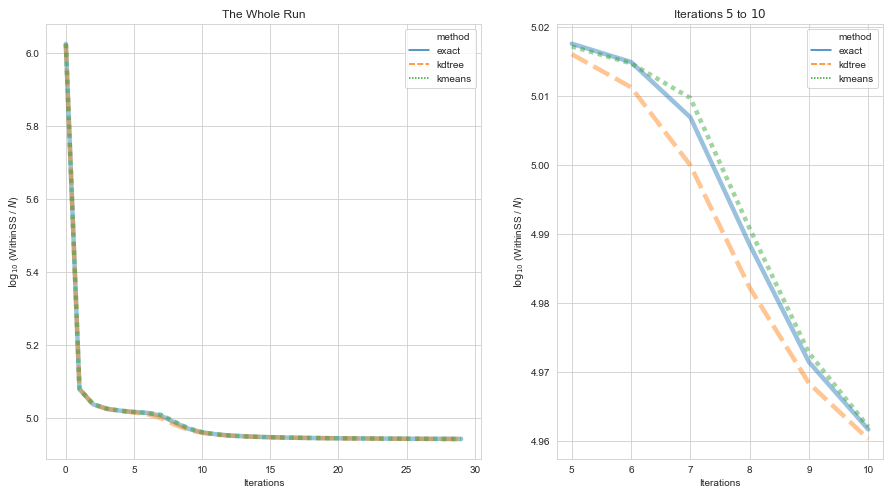

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_style("whitegrid")


df = pd.read_csv('./data/sift_comparison_150_auto-1.csv')
df.loc[:, 'measure'] = np.log10(df.loc[:, 'measure'])

# Plot results
order = sorted(np.unique(df['method']))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), 
                               gridspec_kw={'width_ratios': (2, 1.5)})
sns.lineplot(x='index', y='measure', 
             hue='method', style='method', alpha=.45,
             hue_order=order,
             style_order=order,
             linewidth=4.5,
             ax=ax1, 
             data=df)
ax1.set_xlabel('Iterations')
ax1.set_ylabel(r'$\log_{10}$ (WithinSS / $N$)')
ax1.set_title('The Whole Run')
sns.lineplot(x='index', y='measure', 
             hue='method', style='method', alpha=.45,
             hue_order=order,
             style_order=order,
             linewidth=4.5,
             ax=ax2, 
             data=df[(df['index'] <= 10) & (df['index'] >= 5)])
ax2.set_xlabel('Iterations')
ax2.set_ylabel(r'$\log_{10}$ (WithinSS / $N$)')
ax2.set_title('Iterations $5$ to $10$')
plt.show()